This notebook recreates some key results figures in Merdith et al. (2017) 'Kinematic constraints on the Rodinia to Gondwana transition'.  Most of this notebook is a (semi-futile) effort in plotting and visualising data extracted from a plate model, so I apologise in advance.

The example below is with the Missing Link Model with rifting at 800 Ma.  Rotation files for each of the four main Australia-Laurentia configurations at 800 Ma are provided and can be substituted in and out. It plots the configuration at 650 Ma with flowlines showing the evolution of the artificial ocean basin between South China or Australia, and Laurentia, and the corresponding Euler poles of the stage rotations that define the motion.  It also calcualtes the rate of motion and azimuth of spreading and plots these in a stepwise function.

Unfortunately, cartopy does not support plotting gridlines for Robinson projections (yet) so that plot is a bit bare.  I will try and update this script when the support is integrated into cartopy.  Flowlines can be made in pyGPlates if desired, but it's easiest to make them manually in GPlates as a gpml file and then load them in (which is what I have done here).

This could should be reasonably easy to adapt to other configurations and rifting times.  Simon Williams (https://github.com/siwill22/) wrote some parts of the script to extact poles of rotation and plot them.

References

Merdith, A.S., Williams, S.E., Müller, R.D. and Collins, A.S., 2017. Kinematic constraints on the Rodinia to Gondwana transition. Precambrian Research, 299, pp.132-150.

In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import cartopy.crs as ccrs
import extract_poles
%matplotlib inline

In [2]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2017_PR/Sample_data/'
Mer17PR_rotation_model = pygplates.RotationModel('%sMer17_PR_Aus-Laurentia_800-Missing-Link.rot' % basedir)
Mer17PR_polygons = pygplates.FeatureCollection('%sMer17_PR_Geometries_Aus_Laurentia_South_China.gpml' % basedir)
flowline_features = pygplates.FeatureCollection('%s800_Flowlines_ML.gpml' % basedir)

In [31]:
#setup some parameters for plotting and reconstructing

#date line wrapper
date_line_wrapper = pygplates.DateLineWrapper(180.0)#must be the same when setting up cartopy
#colour list for different flowlines
CList_1 = 'b', 'o', 'g'
CList = ['#1f77b4','#ff7f0e','#2ca02c']
#reconstruction start/end times and some other parameters for extracting Euler poles
end_time = 650
start_time = 800
timestep = 10
moving_plate = 6603
fixed_plate = 1001
#for the colorbar
cb_times = np.arange(650,810,10)
#for calculating and plotting stepwise data and getting Euler poles

time_intervals = np.diff(cb_times)

#reconstruct our data ready for plotting
#flowlines
reconstructed_flowlines = []
pygplates.reconstruct(flowline_features, 
                      Mer17PR_rotation_model, 
                      reconstructed_flowlines, 
                      end_time, 
                      reconstruct_type=pygplates.ReconstructType.flowline)

#polygons for end time
reconstructed_polygons_end_time = []
pygplates.reconstruct(Mer17PR_polygons,
                      Mer17PR_rotation_model,
                      reconstructed_polygons_end_time,
                      end_time)

Longs, Lats, Angles, time_change = extract_poles.poles_of_rotation(end_time, 
                                                                   start_time, 
                                                                   timestep, 
                                                                   Mer17PR_rotation_model, 
                                                                   moving_plate, 
                                                                   fixed_plate) #euler pole positions

threshold = 10
angles_degrees = np.degrees(Angles)
marker_size = []

#we are going to change the size of the Euler Pole when it's angle of rotation is above <threshold>
for val in angles_degrees:
    if val > threshold:
        marker_size.append(20)
    else:
        marker_size.append(5)
marker_size = np.array(marker_size)


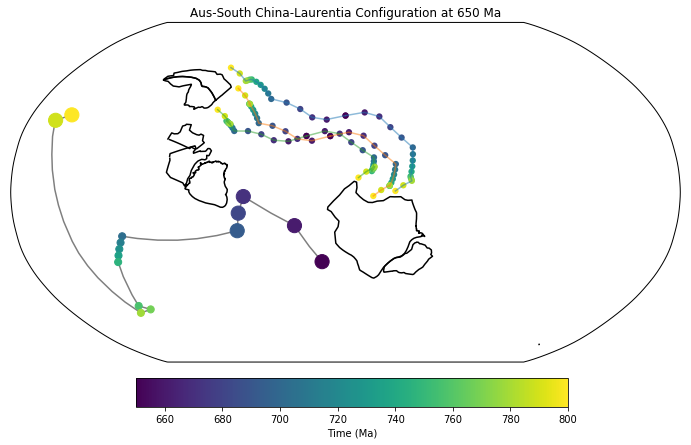

In [32]:
#plotting time
#NB Cartopy currently only support gridlines on platecaree or mercator projections :*(
#apparently this capacity is coming soon, so once it is I will update the plot

fig, ax = plt.subplots(nrows=1, 
                        ncols=1,
                        figsize=(12,8),
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})
data_crs = ccrs.Geodetic()
ax.set_global()

#plot polygons          
for polygon in reconstructed_polygons_end_time:
    polygon_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry()) #make sure they are all actually polyogns
    wrapped_coastlines = date_line_wrapper.wrap(polygon_geom, 1)
    for wrapped_coastline in wrapped_coastlines:
            wrapped_coastlines_lat = []
            wrapped_coastlines_lon = []
            for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
                wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
                wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())

            ax.plot(wrapped_coastlines_lon, 
                     wrapped_coastlines_lat, 
                     color='k', 
                     transform=data_crs)

#plot Euler rotations of stage poles
ax.plot(Longs, Lats, color='k', transform=data_crs, zorder=0, alpha=0.5)
ax.scatter(Longs, Lats, 
           s=(marker_size*10),
           c=np.arange(end_time, 
                       start_time, 
                       timestep),
           cmap=plt.cm.viridis,
           transform=data_crs)
#plot flowlines   
#we need a count to colour each flowline properly
count = 0
#each flowline contains two subcomoponents, one tracing the left moving plate, the other tracing the right moving plate
#we need to extract each separately to plot both
for reconstructed_flowline in reconstructed_flowlines:
    flowlinearray_left = np.empty([0,0])
    flowlinearray_right = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())
    
    #get lat/lon from left flowlinearray
    x, y = flowlinearray_left[1::2],flowlinearray_left[::2]
    ax.plot(x, y,
             c=CList[count],
             zorder=2,
             alpha=0.5,
             transform=data_crs)
    #sorry, FLP for flowline point
    #this plots 10 Ma intervals as a shape for clarity
    FLP = ax.scatter(x, y, 40, 
                     c=cb_times,
                     cmap=plt.cm.viridis,
                     edgecolor='none',
                     vmin=end_time,
                     vmax=start_time,
                     zorder=1,
                     transform=data_crs)

    #get lat/lon from right flowline array
    x, y = flowlinearray_right[1::2],flowlinearray_right[::2]
    ax.plot(x, y,
             c=CList[count],
             zorder=2,
             alpha=0.5,
             transform=data_crs)
    FLP = ax.scatter(x, y, 40,
                     c=cb_times,
                     cmap=plt.cm.viridis,
                     edgecolor='none',
                     vmin=end_time,
                     vmax=start_time,
                     zorder=1,
                     transform=data_crs)        
    count = count+1
ax.set_title('Aus-South China-Laurentia Configuration at 650 Ma')    
#make an ugly colourbar
cbax = fig.add_axes([0.27, 0.13, 0.5, 0.05])
cbar = plt.colorbar(FLP, cax=cbax, orientation='horizontal')
cbar.set_label('Time (Ma)')

Text(0.5,0,'Time (Ma)')

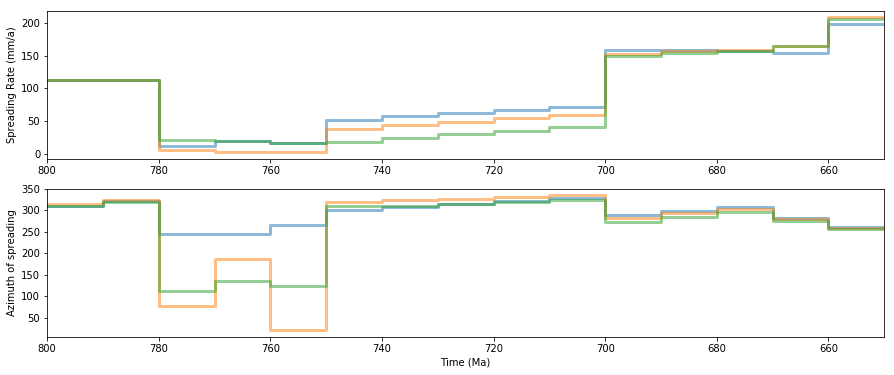

In [67]:
#plotting 2, get some numbers

#we only want one plot so we initiate it outside the for loop
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,6))

#to save the numbers
average_velocity = []
orientation = []
#need a count because we are colour-coding 
count = 0
#loop through our flowlines
for reconstructed_flowline in reconstructed_flowlines:
    flowlinearray_left = np.empty([0,0])
    flowlinearray_right = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

    #we just use one flowline since they should be mirror images of each other (numerically, not absolutely geometrically)
    tmp = reconstructed_flowline.get_left_flowline()
    #we want distance, direction (or azimuth) and rate (as in spreading rate or velocity)
    Dist = []
    Direc = []
    Rate = []
    #loop through segments of each flowling
    #remember our time resolution on flowlines was 10 Ma, so each segment corresponds to 10 Ma of motion
    for segment in tmp.get_segments():
        #distance
        Dist.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)

        SP = segment.get_start_point().to_lat_lon()
        EP = segment.get_end_point().to_lat_lon()
        #get azimuth        
        deviation_of_segment_direction_from_north = extract_poles.Get_FZ_Directions(SP[1],SP[0],EP[1],EP[0])
        #transform it to 0—360
        if deviation_of_segment_direction_from_north>360:
            deviation_of_segment_direction_from_north = deviation_of_segment_direction_from_north-360
        Direc.append(deviation_of_segment_direction_from_north)
    
    Rate = 2*np.asarray(Dist)/time_intervals

    #convert values to stepwise per time interval
    StepRate = np.zeros(len(Rate)*2)
    StepRate[::2] = Rate
    StepRate[1::2] = Rate

    StepDirec = np.zeros(len(Direc)*2)
    StepDirec[::2] = Direc
    StepDirec[1::2] = Direc

    StepTime = np.zeros(len(Rate)*2)
    StepTime[::2] = cb_times[:-1]
    StepTime[1::2] = cb_times[1:]

    ax1.plot(StepTime, StepRate, linewidth = 3, c = CList[count], alpha = 0.5)
    ax2.plot(StepTime, StepDirec, linewidth = 3, c = CList[count], alpha = 0.5)
    
    average_velocity.append(StepRate)
    orientation.append(StepDirec)

    count=count+1
    
ax1.set_xlim(800,650)
ax2.set_xlim(800,650)
ax1.set_ylabel('Spreading Rate (mm/a)')
ax2.set_ylabel('Azimuth of spreading')
ax2.set_xlabel('Time (Ma)')